## Title

Diagnosing Heart Disease with Cardiovascular Measurements 

## Introduction

Cardiovascular disease is a lethal medical condition that reduces blood flow to parts of the body due to plaque buildup in the arteries. Over time, the plaque buildup will restrict sufficient blood supply to important organs of the body and can result in strokes, heart attacks and death. Physicians conduct multiple examinations to diagnose patients with heart disease, however this is quite time consuming in a medical field and a more effective diagnosis tool is necessary. In this data analysis I will use the heart disease data set from the UCI Machine Learning Repository that contains cardiovascular information of 303 individuals from Cleveland, Ohio in 1988 to answer the following question: given information about a patient’s cholesterol, resting blood pressure and maximum heart rate after exercise, can I predict the presence of heart disease? A classification analysis using cholesterol levels, resting blood pressure and maximum heart rate as predictor variables will be used to answer this question.


## Methods and Results

#### Preliminary Data Analysis

I selected the variables described in the introduction to be predictors because they are the most relevant to predicting my target variable, the presence of heart disease. Studies highlight exposure to high cholesterol levels and unhealthy blood pressure is correlated with high risk for heart disease (Zhang et al., 2019). Further, subjection to poor measurements of cholesterol and blood pressure at younger ages increases the risk of developing heart disease (Zhang et al., 2019). Studies also emphasize a correlation between high heart rate and cardiovascular disease and further argue that high heart rate is also correlated with poor blood pressure, which is known to promote heart disease (Perret-Guillaume et al., 2009), (Zhang et al., 2019). A small note is that the heart rate referenced in the studies are average resting heart rates, while the one in this data set is maximum heart rates. However, I believe that the two are close enough to be used interchangabely, since the data set does not have restin heart rate.The significant correlations between my predictor variables and cardiovascular disease make them the most relevant predictors for my analysis.

I load the relevant packages to my data analysis using the library function. The tidyverse package allows me to use functions to load and wrangle my dataset. The tidymodels package provides functions that are relevant to creating my classification model. I also set a seed value to ensure all of my work is reproducible.

In [2]:
set.seed(1772)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))

#The supressPackageStartupMessages function used while loading in the libraries hides the start-up messages 
#that appear when loading in these packages, this was done for clarity purposes.

I use the read_csv command to load in the dataset from the web. Furthermore, I specify that the raw data set did not have any column names and I used the rename command to manually add them in.

In [4]:
url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
#Assigning dataset to an object

cleveland_heart_data<-read_csv(url, col_names=FALSE)%>% 
rename(age=X1, #Names of the variables were found on the website with the dataset assigned to the url object
       sex=X2,
       cp=X3,
       trestbps=X4,
       chol=X5,
       fbs=X6,
       restecg=X7,
       thalach=X8,
       exang=X9,
       oldpeak=X10,
       slope=X11,
       ca=X12,
       thal=X13,
       num=X14)     

#Variables:
#cp = type of chest pain
#trestbps = resting blood pressure (mm/Hg)
#chol = cholesterol (mg/dl)
#fbs = fasting blood sugar (mg/dl)
#restecg = electrocardiographic results (0=normal, 1=abnormal, 2=hypertrophy)
#thalach = maximum heart rate
#exang = exercise induced angina
#oldpeak = ST depression induced by exercise relative to rest
#slope = the slope of the peak exercise ST segment
#ca = number of major vessels colored by flourosopy
#thal = defect Type (3.0 = normal, 6.0 = fixed defect, 7.0 = reversible defect)
#num = diagnosis
head(cleveland_heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


The original data set is difficult to understand as it represents the values of character variables with numbers. In order to better comprehend the dataset, I use the ifelse function to convert the variables represented by numbers into characters.

In [5]:
cleveland_heart_data$sex<-ifelse(cleveland_heart_data$sex == 1, 'male', 'female') 
#Changing sex variable from 0 and 1 to male and female

cleveland_heart_data$fbs<-ifelse(cleveland_heart_data$fbs == 1, '>120', '<120')
#Changing fbs variable from 0 and 1 to >120 and <120

cleveland_heart_data$exang<-ifelse(cleveland_heart_data$exang == 1, 'yes', 'no')
#Changing exang variable from 0 and 1 to yes and no

cleveland_heart_data$num<-ifelse(cleveland_heart_data$num == 0, 'no_disease', 'has_disease')
#Changing num variable from integers to no_disease and has_disease
cleveland_heart_data$cp<-ifelse(cleveland_heart_data$cp == 1, 'typical_angina',
                                ifelse(cleveland_heart_data$cp == 2, 'atypical_angina',
                                       ifelse(cleveland_heart_data$cp == 3, 'non_anginal_pain', 'asymptomatic')))
#Changing cp variable from integers to typical_angina, atypical_angina, non_anginal_pain and asymptomatic

cleveland_heart_data$slope<-ifelse(cleveland_heart_data$slope == 1, 'upsloping',
                                   ifelse(cleveland_heart_data$slope == 2, 'flat', 'downsloping'))
#Changing slope variable from integers to upslopping, flat and downslopping
head(cleveland_heart_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
63,male,typical_angina,145,233,>120,2,150,no,2.3,downsloping,0.0,6.0,no_disease
67,male,asymptomatic,160,286,<120,2,108,yes,1.5,flat,3.0,3.0,has_disease
67,male,asymptomatic,120,229,<120,2,129,yes,2.6,flat,2.0,7.0,has_disease
37,male,non_anginal_pain,130,250,<120,0,187,no,3.5,downsloping,0.0,3.0,no_disease
41,female,atypical_angina,130,204,<120,2,172,no,1.4,upsloping,0.0,3.0,no_disease
56,male,atypical_angina,120,236,<120,0,178,no,0.8,upsloping,0.0,3.0,no_disease


Next, I convert the num variable into a factor type using the mutate and as_factor functions. The num variable will serve as the response variable in my analysis, therefore I need to ensure that it is recognized as a categorical variable so that the classifier understands there is a set number of values possible to use when classifying an observation.

In [6]:
cleveland_heart_data<-cleveland_heart_data%>%
mutate(num=as_factor(num))

Further, I select only the variables that are relevant for my classification problem using the select function.

In [7]:
cleveland_heart_data<-cleveland_heart_data%>%
select(chol, trestbps, thalach, num)
head(cleveland_heart_data)

chol,trestbps,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
233,145,150,no_disease
286,160,108,has_disease
229,120,129,has_disease
250,130,187,no_disease
204,130,172,no_disease
236,120,178,no_disease


To gain more insight about the dataset, I create a summary table showing a count of how many observations show the presence or absence of heart disease. I first group_by my response variable column and then apply summarize to generate a count of each category of the num variable. This summary table allows me to compare the amount of observations for each category of the response variable in the dataset.

In [8]:
class_count<-cleveland_heart_data%>%
group_by(num)%>%
summarize(n=n())
class_count

#164 observations show an absence of heart disease
#139 observations show the presence of heart disease

num,n
<fct>,<int>
no_disease,164
has_disease,139


TABLE 1 -

Table 1 provides a count of the response variables categories. This table illustrates that there is a relatively equally count of both categories present in the data set.

I also plot scatterplots of all predictor variables by calling the ggplot and geom_point functions. The scatterplots are coloured by the presence or absence of heart disease. These scatterplots provide me with useful insight about the relationships between each of the predictor variables and if the presence of heart disease has any correlation with the predictors.

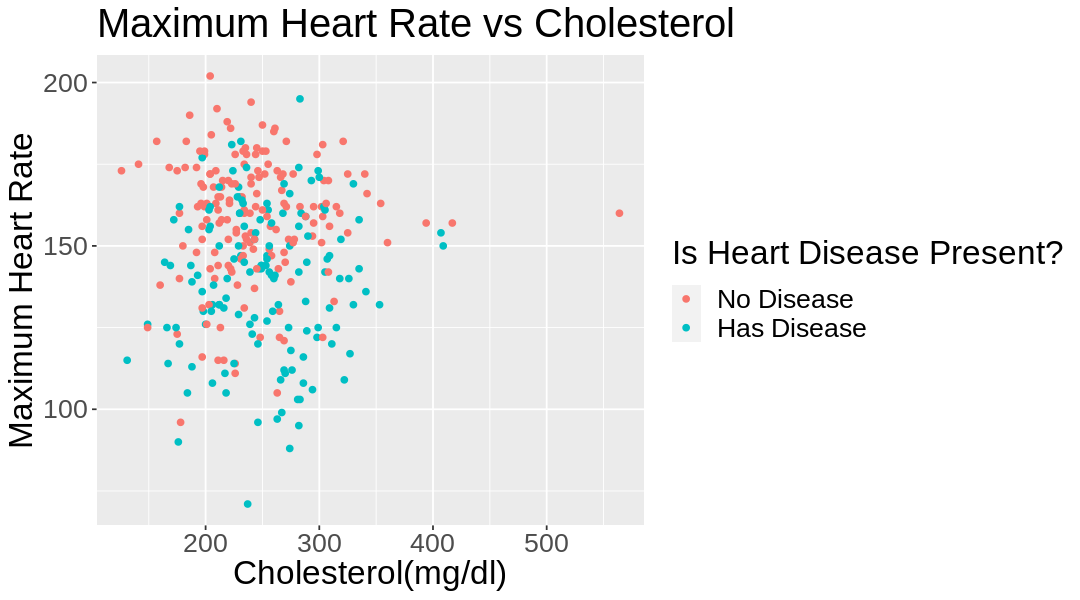

In [14]:
options(repr.plot.width=9,repr.plot.height=5)
chol_vs_thalach<-cleveland_heart_data%>% #Cholesterol vs Max. Heart Rate
ggplot(aes(x=chol, y=thalach, color=num))+
geom_point()+
scale_color_discrete(name = "Is Heart Disease Present?", labels=c('No Disease', 'Has Disease'))+
labs(x="Cholesterol(mg/dl)", y="Maximum Heart Rate")+
theme(text=element_text(size=20))+
ggtitle("Maximum Heart Rate vs Cholesterol")

#I utilized the labs, theme, scale-color_discrete and ggtitle functions to improve the visualization of the scatterplot 
#by adjusting the font size and adding appropriate axis labels. I will continute to do so in all future visuals.

chol_vs_thalach

FIGURE 1 - 

Figure 1 represents the scatterplot of maximum heart rate plotted against cholesterol levels (mg/dl). There is no relationship between maximum heart rate and cholesterol levels and the graph depicts no linearity between the two variables. Further, the graph illustrates that the presence heart disease is not correlated with the two variables plotted.

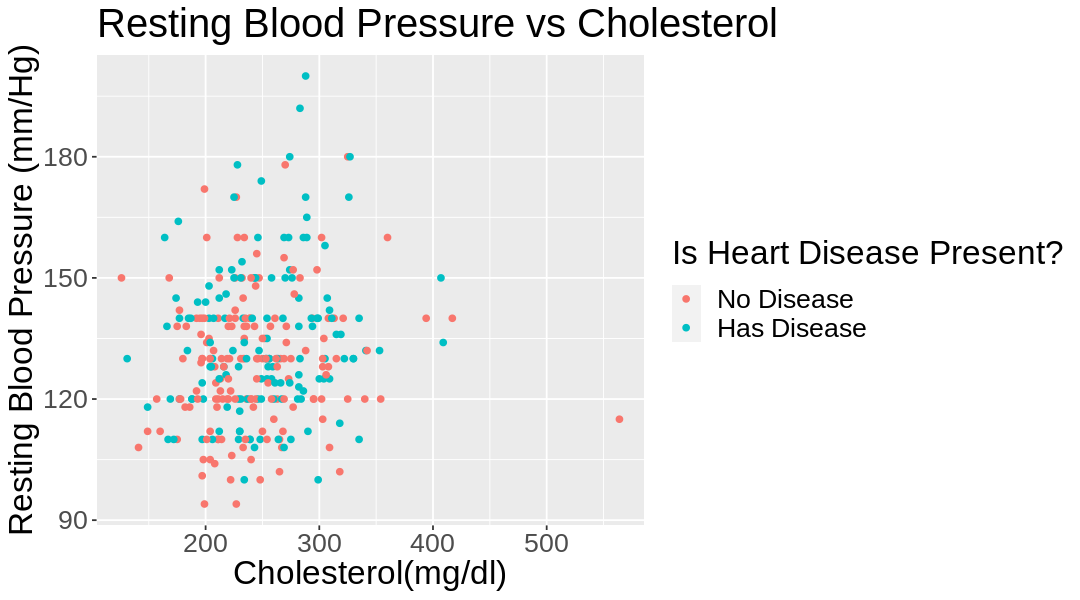

In [15]:
options(repr.plot.width=9,repr.plot.height=5)
chol_vs_trestbps<-cleveland_heart_data%>% #Cholesterol vs Blood Pressure
ggplot(aes(x=chol, y=trestbps, color=num))+
geom_point()+
scale_color_discrete(name = "Is Heart Disease Present?", labels=c('No Disease', 'Has Disease'))+
labs(x="Cholesterol(mg/dl)", y="Resting Blood Pressure (mm/Hg)")+
theme(text=element_text(size=20))+
ggtitle("Resting Blood Pressure vs Cholesterol")


chol_vs_trestbps

FIGURE 2 -

Figure 2 represents the scatterplot of resting blood pressure (mm/Hg) plotted against cholesterol levels (mg/dl). There is no relationship between resting blood pressure and cholesterol levels and the graph shows no linearity between the two variables. Further, the graph illustrates that the presence of heart disease is not correlated with the two variables plotted.

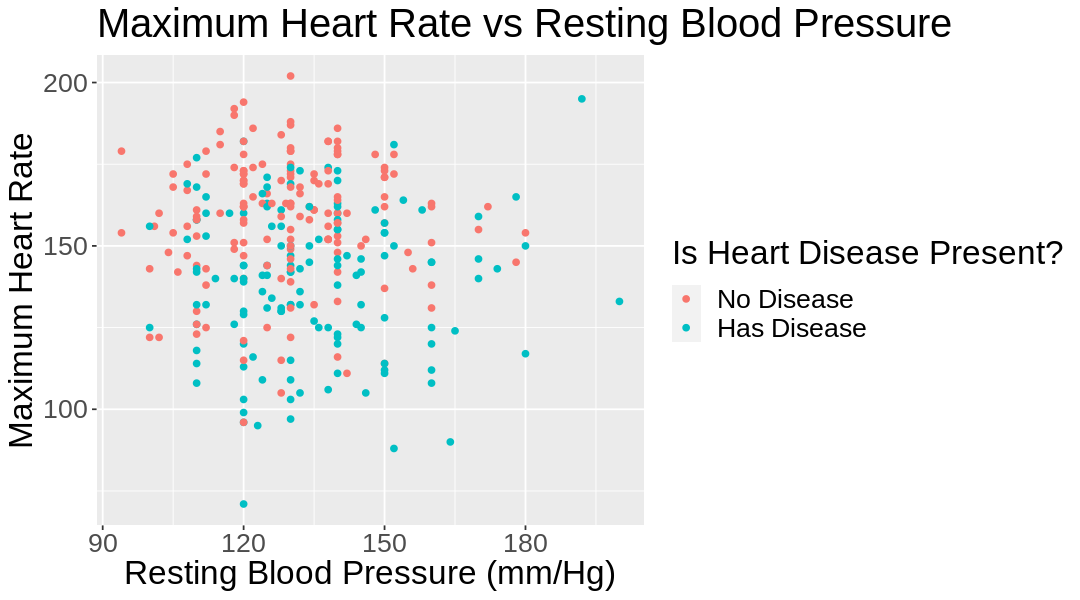

In [18]:
options(repr.plot.width=9,repr.plot.height=5)
trestbps_vs_thalach<-cleveland_heart_data%>% #Blood Pressure vs Max. Heart Rate
ggplot(aes(x=trestbps, y=thalach, color=num))+
geom_point()+
scale_color_discrete(name = "Is Heart Disease Present?", labels=c('No Disease', 'Has Disease'))+
labs(x="Resting Blood Pressure (mm/Hg)", y="Maximum Heart Rate")+
theme(text=element_text(size=20))+
ggtitle("Maximum Heart Rate vs Resting Blood Pressure")


trestbps_vs_thalach

FIGURE 3 -

Figure 3 represents the scatterplot of maximum heart rate plotted against resting blood pressure (mm/Hg). The graph shows that there is no relationship between maximum heart rate and resting blood pressure and it also shows there is no linearity in the plot. It further shows that the presence of heart disease is not correlated with the two variables plotted.

#### Building The Model

Before I begin training the classification model, I randomly split the overall data frame into a training subset and a testing subset using the initial_split function. The training dataset will be used to train the classification model and the testing dataset will be used to determine the classifier's accuracy after it has been trained. I have specified to devote 75% of the initial data to the training dataset and 25% of it to the testing data set by specifying that prop=0.75 in the initial_split function. Furthermore, I also specify that strata=num, to ensure that both the training and testing datasets have equal proportions of the 'has_disease' and no_disease' categories.

In [32]:
heart_split<-initial_split(cleveland_heart_data, prop=0.75, strata=num)
heart_train<-training(heart_split)
heart_test<-testing(heart_split)

head(heart_train)
head(heart_test)

chol,trestbps,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
286,160,108,has_disease
229,120,129,has_disease
254,130,147,has_disease
203,140,155,has_disease
256,130,142,has_disease
229,110,168,has_disease


chol,trestbps,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
268,140,160,has_disease
263,120,173,no_disease
239,140,160,no_disease
275,130,139,no_disease
211,110,144,no_disease
283,150,162,no_disease


Next I begin to pre-process the training data set, I accomplish this by creating a recipe by using the recipe function. I specify to use the 'num' column as the response variable, and that cholesterol, resting blood pressure and maximum heart rate are the predictor variables for this analysis. I further specify I am creating this recipe from only the training data. Afterwards I center and scale all predictor variables so that all of the predictor variables are on an equal scale and contribute equally to finding the nearest neighbor through the distance formula. This was accomplished by using the step_scale and step_center functions respectively.

I create a model specification by using the nearest_neighbor function. I set the weight_func argument to rectangular to inform the model to use the straight line distance formula when calculating the distance between points and to ensure each neighbor contributes one vote when classifying a new observation. I need to use cross-validation to pick the best K value for the model so I set the neighbors argument to tune(). This allows me to determine the accuracy for a list of k values that I specify in the next steps. To finalize the model specification, I indicate that the model will be trained using a k-nearest neighbor computational engine and that it will be addressing a classification problem by using the set_engine and set_mode functions.


In [22]:
heart_recipe<-recipe(num ~ chol+trestbps+thalach, data=heart_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

heart_knn<-nearest_neighbor(weight_func="rectangular", neighbors=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

heart_recipe
heart_knn

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


I use the tibble function to create a table that has a list of values from 1 to 100 increasing by increments of 2. These are the values of k whose accuracy I have chosen to compute during the cross validation analysis. I limit the parameters to odd integers to prevent a tie in voting and stop at 100 to ensure there is enough computational power to execute cross-validation.

In [23]:
gridvals<-tibble(neighbors=seq(from=1, to=100, by=2))
head(gridvals)

neighbors
<dbl>
1
3
5
7
9
11


Next I apply the vfold_cv function to setup the information that I need to execute cross-validation. I specify that I am going to perform a 5-fold cross validation by setting v=5. I restricted the analysis to 5-folds to ensure the computation is not too expensive. I also indicate that there should be equal numbers of each category for the response variable in each of the 5 folds of data by setting strata=num.

In [24]:
heart_vfold<-vfold_cv(heart_train, v=5, strata=num)

To execute the cross validation, I add the recipe and model I created in the previous steps into a workflow. I then call the tune_grid function to fit the model on to the range of possible k values in the table and execute cross validation using the measures that I defined in the previous step. Afterwards I call collect_metrics to provide the statistical results of the cross validation and filter for only the accuracy metric as this is the only measurement relevant to the analysis. I finally arrange the data frame such that the accuracy is arranged in descending order.

In [25]:
knn_heart_results<-workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(heart_knn)%>%
    tune_grid(resamples=heart_vfold, grid=gridvals)%>%
    collect_metrics()%>%
    filter(.metric=="accuracy")%>%
    arrange(by=desc(mean))
head(knn_heart_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
33,accuracy,binary,0.6957751,5,0.02006072,Preprocessor1_Model17
31,accuracy,binary,0.6869829,5,0.02099110,Preprocessor1_Model16
47,accuracy,binary,0.6869829,5,0.01860399,Preprocessor1_Model24
11,accuracy,binary,0.6868950,5,0.02430654,Preprocessor1_Model06
29,accuracy,binary,0.6868863,5,0.01468857,Preprocessor1_Model15
17,accuracy,binary,0.6865964,5,0.02233902,Preprocessor1_Model09


I illustrate the results of the cross-validation by plotting a line graph of accuracy estimate vs K to help  determine which of the k values is optimal for the model. I use the ggplot command to construct the graph and use geom_point and geom_line respectively to overlay the points and line on to the graph.

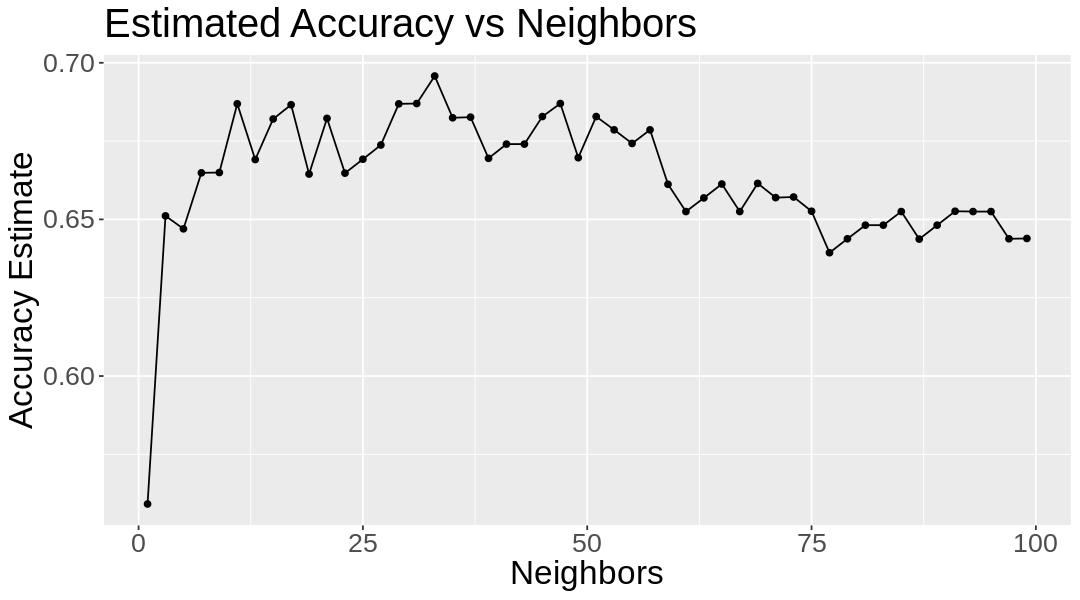

In [26]:
knn_heart_graph<-knn_heart_results%>%
ggplot(aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x="Neighbors", y="Accuracy Estimate")+
theme(text=element_text(size=20))+
ggtitle("Estimated Accuracy vs Neighbors")


knn_heart_graph

FIGURE 4 -

Figure 4 shows the plot of the accuracy estimate for each k-neighbor tested during cross-validation. The graph indicates that k=41 neighbors is optimal for the model I am constructing as it has the highest accuracy estimate of all the k values tested, and changing this value slightly does not result in very large changes in accuracy.

I now re-make a model specification with the optimal k value that was extracted from the plot above. I still specify that I want to use the straight line distance to calculate distance between points in the training data and the computational engine and mode remain the same. Finally, I add the new model specification and the recipe (the same recipe created earlier), to a workflow and fit the data on to the training dataset to complete the training of the classification model.

In [27]:
knn_heart_best<-nearest_neighbor(weight_func="rectangular", neighbors=41)%>%
    set_engine("kknn")%>%
    set_mode("classification")

heart_fit<-workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(knn_heart_best)%>%
    fit(data=heart_train)

knn_heart_best
heart_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 41
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(41,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3259912
Best kernel: rectangular
Best k: 41

To assess the accuracy of the model, I use the classifier to predict the labels of the testing data set that was created at the beginning of this analysis. This is an appropriate method to determine an estimate of how accurate the model is because the classifier has not seen the data from the testing set. I use the predict function to tell the classifier to make predictions on the testing data set and add the results it produces as a column to the test data set. Further I call the metrics function to provide the statistical results of the predictions and filter for accuracy as this is the only measurement relevant to this analysis. Based on this report I can conclude that the accuracy of the classifier is approximately 68%.

In [28]:
heart_predictions<-heart_fit%>%
    predict(heart_test)%>%
    bind_cols(heart_test)

In [29]:
heart_accuracy<-heart_predictions%>%
metrics(truth=num, estimate=.pred_class)%>%
filter(.metric=="accuracy")
heart_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6842105


To illustrate the accuracy of the classifier and understand the patterns the model discovered, I use the ggplot and geom_point functions to create scatterplots of two of the predictor variables. In one of the graphs I colour the data points by the true category of the response variable and in the other I colour them by the predicted category made by the classifier.

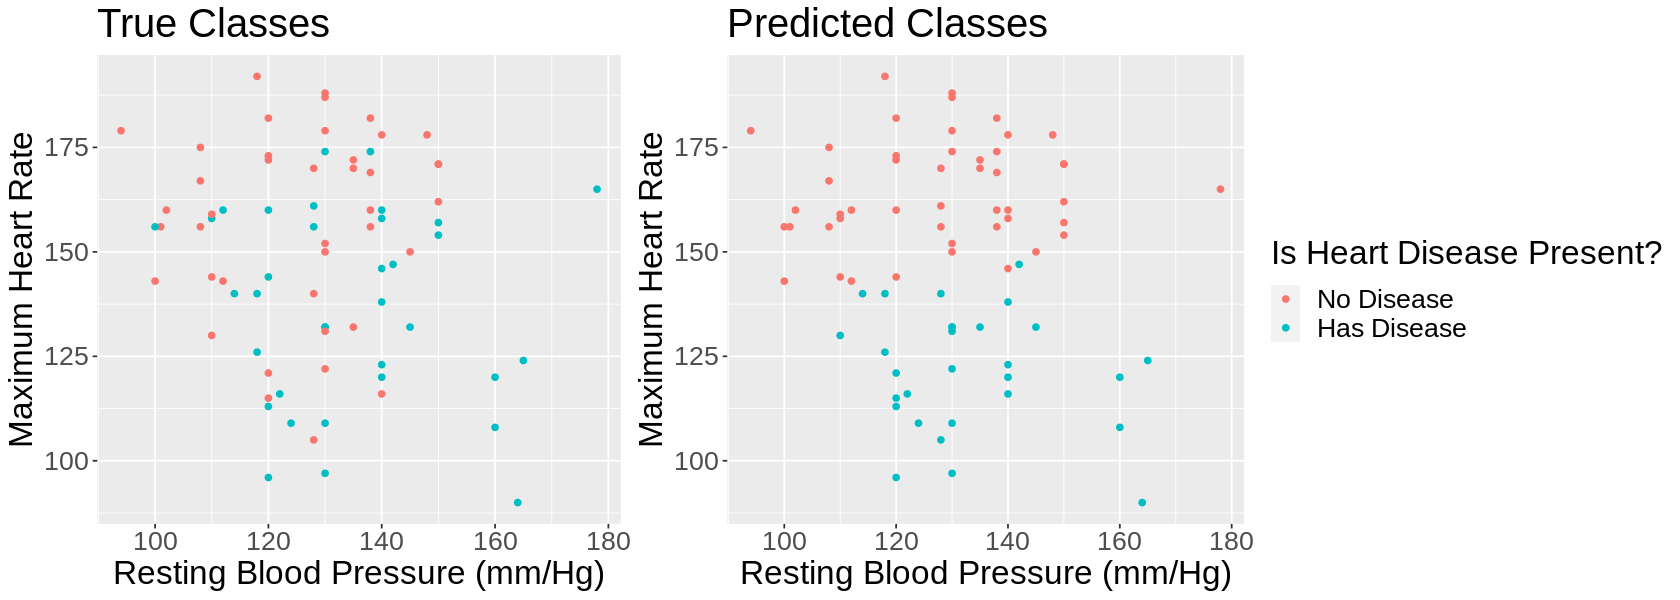

In [56]:
library(cowplot)
options(repr.plot.width=14,repr.plot.height=5)
actual_classes<-heart_predictions%>%
ggplot(aes(x=trestbps, y=thalach, color=num), show.legend = FALSE)+
geom_point()+
#scale_color_discrete(name = "Is Heart Disease Present?", labels=c('No Disease', 'Has Disease'))+
labs(x="Resting Blood Pressure (mm/Hg)", y="Maximum Heart Rate")+
theme(text=element_text(size=20), legend.position="none")+
ggtitle("True Classes")  


predicted_classes<-heart_predictions%>%
ggplot(aes(x=trestbps, y=thalach, color=.pred_class))+
geom_point()+
scale_color_discrete(name = "Is Heart Disease Present?", labels=c('No Disease', 'Has Disease'))+
labs(x="Resting Blood Pressure (mm/Hg)", y="Maximum Heart Rate")+
theme(text=element_text(size=20))+
ggtitle("Predicted Classes")           

plot_grid(actual_classes, predicted_classes, ncol=2, rel_widths = c(1.2, 2))

FIGURE 5&6 -

Figure 5 illustrates a scatterplot of maximum heart rate plotted against resting blood pressure (mm/Hg) coloured by the true category of the response variable. There is no relationship between the plotted variables and the graph depicts no linearity. Further, there is no correlation between the presence of heart disease and the predictors plotted on the graph.

Figure 6 illustrates a scatterplot of maximum heart rate plotted against resting blood pressure (mm/Hg) coloured by the predicted category of the response variable made by the classifier. There is no relationship between maximum heart rate and resting blood pressure and the graph depicts no linearity. Unlike Figure 5 this graph illustrates that a higher maximum heart rate is correlated with the presence heart disease.

### Discussion

Ultimately my classification model to detect heart disease using cholesterol, blood pressure and heart rate was 68% accurate, meaning I cannot accurately detect heart disease with these predictors. I found that the classifier incorrectly learned to detect heart disease with rising heart rate as shown in Figures 5 and 6 and is likely a key reason for low accuracy. The imprecise accuracy was unexpected because the predictor variables used in the analysis are said to be highly correlated with cardiovascular disease as discussed at the beginning of the preliminary data analysis. Part of it could be attributed to the fact that we used maximum heart rate after exercise instead of average resting heart rate. Due to the low accuracy the classifier, it will not have immediate impacts in a medical setting. However, the patterns detected by the classifier will provide insightful information for data analysts working to perfect machine learning algorithms to detect disease and perhaps a refined version of this algorithm will serve as a diagnosis tool in the future. This report may lead to future questions about the strength of correlation between heart disease and my predictor variables which may lead to changes in medical diagnosis procedures. Further, discussions about what predictors are appropriate to use in similar or follow up data analysis may be facilitated as this report illustrates that my predictor variables may not actually be as strongly correlated with heart disease.

### References

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (2019). Heart Disease Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. Progress in Cardiovascular Diseases, 52(1), 6–10. https://doi.org/10.1016/j.pcad.2009.05.003

Zhang, Y., Vittinghoff, E., Pletcher, M. J., Allen, N. B., Zeki Al Hazzouri, A., Yaffe, K., Balte, P. P., Alonso, A., Newman, A. B., Ives, D. G., Rana, J. S., Lloyd-Jones, D., Vasan, R. S., Bibbins-Domingo, K., Gooding, H. C., de Ferranti, S. D., Oelsner, E. C., & Moran, A. E. (2019). Associations of Blood Pressure and Cholesterol Levels During Young Adulthood With Later Cardiovascular Events. Journal of the American College of Cardiology, 74(3), 330–341. https://doi.org/10.1016/j.jacc.2019.03.529